# Perkenalan
Nama : Arvin Melvillo \
Batch : FTDS - RMT - 020 \
Dataset : [Hotel Reservation Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) \
Latar belakang : Hotel Liburan Skuuy, merupakan sebuah hotel yang sedang naik daun di Bali. Pada tahun 2017 dan 2018, Liburan Skuy mengumpulkan data para customer yang membooking hotel dengan Online. Namun beberapa customer ada yang tidak jadi menempati kamar hotel baik secara diam diam tanpa kabar ataupun dengan melakukan pembatalan terlebih dahulu. Untuk mencegah pembookingan yang gagal oleh customer, Liburan Skuy meminta tim data scientistnya untuk memprediksi order yang memiliki kemungkinan untuk batal booking, supaya Liburan Skuy dapat memberikan kamar tersebut ke customer lain. \
Objective : Memprediksi apakah order tersebut akan dibatalkan nantinya atau tidak. \
Pengerjaan : Pada kasus ini, data scientist akan memprediksi dengan menggunakan 7 model yaitu **Logistic Regression**, **SVM**, **KNN**, **Naive Bayes**, **Decision Tree**, **Random Forest** dan **XGBoost**. Nantinya 3 model dengan performa terbaik pada base modelnya akan di tuning lagi, lalu model terbaik setelah dituning akan disimpan untuk melakukan prediksi pembatalan kartu kredit di bulan depannya. Metrics yang digunakan untuk membandingkan model adalah Recall untuk menghitung performa model baik dari nilai False Negative. Hal tersebut karena Liburan Skuy hanya ingin memberikan kamar dari booking yang benar benar di cancel agar tidak terjadi pertikaian antara customer dan front office nantinya. Oleh karena itu, kita butuh nilai dimana model dapat **memprediksi kondisi dengan benar** dengan meminimalkan **False Negative**.

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Library for split, standardrize, and encode the dataset
from sklearn.model_selection import train_test_split #Split
from sklearn.preprocessing import MinMaxScaler #Scale
from sklearn.preprocessing import OrdinalEncoder #Encode

# For handle outlier
from feature_engine.outliers import Winsorizer

# For Feature Selection
from sklearn.feature_selection import chi2

# For Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# For Hyperparameter and cros validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score

# Data Loading

In [2]:
data = pd.read_csv("deployment/Hotel Reservations.csv")

In [3]:
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [4]:
data.duplicated().sum() # Melihat data total data duplikat

0

In [5]:
data_copy = data.copy()

In [6]:
data.head(10) # Memanggil 10 data pertama

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,10,15,Online,0,0,0,107.55,1,Not_Canceled
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,Not_Canceled
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,Not_Canceled
9,INN00010,2,0,0,5,Meal Plan 1,0,Room_Type 4,44,2018,10,18,Online,0,0,0,133.44,3,Not_Canceled


In [7]:
data.tail(10) # Memanggil 10 data terakhir

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
36265,INN36266,2,0,1,3,Meal Plan 1,0,Room_Type 1,15,2018,5,30,Online,0,0,0,100.73,0,Not_Canceled
36266,INN36267,2,0,2,2,Meal Plan 1,0,Room_Type 2,8,2018,3,4,Online,0,0,0,85.96,1,Canceled
36267,INN36268,2,0,1,0,Not Selected,0,Room_Type 1,49,2018,7,11,Online,0,0,0,93.15,0,Canceled
36268,INN36269,1,0,0,3,Meal Plan 1,0,Room_Type 1,166,2018,11,1,Offline,0,0,0,110.00,0,Canceled
36269,INN36270,2,2,0,1,Meal Plan 1,0,Room_Type 6,0,2018,10,6,Online,0,0,0,216.00,0,Canceled
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled
36274,INN36275,2,0,1,2,Meal Plan 1,0,Room_Type 1,207,2018,12,30,Offline,0,0,0,161.67,0,Not_Canceled


# Explarotary Data Analysis 

Sebelum memulai analisa data, mari lihat total data, tipe - tipe data, dan missing value pada data ini.

In [8]:
data.shape

(36275, 19)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [10]:
data.isnull().sum().sort_values(ascending=False).head()

Booking_ID                              0
arrival_month                           0
no_of_special_requests                  0
avg_price_per_room                      0
no_of_previous_bookings_not_canceled    0
dtype: int64

Data pada kasus ini tidak memiliki data yang NULL atau missing values. Namun apakah data ini memiliki cardinality yang tinggi?

In [11]:
cat_col = ['type_of_meal_plan','required_car_parking_space','room_type_reserved','market_segment_type','repeated_guest']
num_col = ['no_of_adults','no_of_children','no_of_weekend_nights','no_of_week_nights','lead_time','arrival_year','arrival_month',
           'arrival_date','no_of_previous_cancellations','no_of_previous_bookings_not_canceled','avg_price_per_room','no_of_special_requests']

In [12]:
data[cat_col].nunique()

type_of_meal_plan             4
required_car_parking_space    2
room_type_reserved            7
market_segment_type           5
repeated_guest                2
dtype: int64

Data - data pada kasus ini tidak memiliki cardinality yang tinggi, mari cek data data unik pada data category

In [13]:
for i in data[cat_col]:
    print(f'Unique data of {i}: ', data[i].unique())

Unique data of type_of_meal_plan:  ['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']
Unique data of required_car_parking_space:  [0 1]
Unique data of room_type_reserved:  ['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
Unique data of market_segment_type:  ['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']
Unique data of repeated_guest:  [0 1]


Setelah melihat data - data unik pada data kategori, mari kita lihat karakteristik dari order di Liburan Skuy

<Axes: title={'center': 'What kind of meal plan the customer want?'}, xlabel='type_of_meal_plan'>

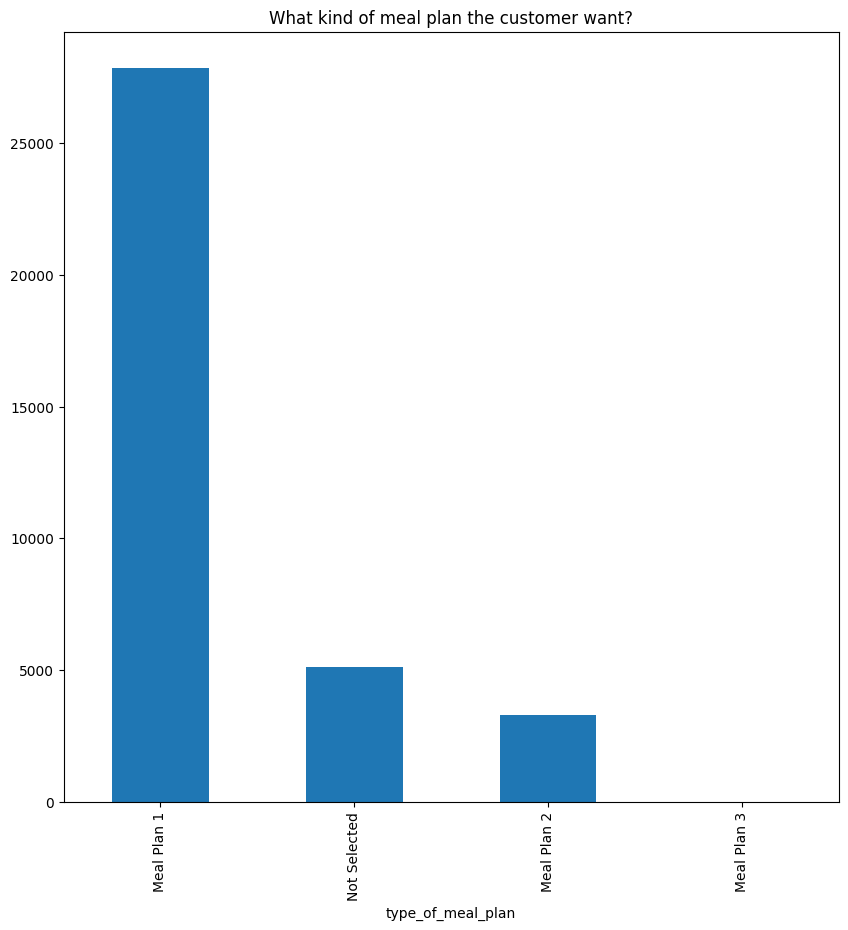

In [14]:
data.groupby('type_of_meal_plan')['Booking_ID'].count().sort_values(ascending=False).plot.bar(x='type_of_meal_plan',y='booking_status', 
    figsize=(10,10), title='What kind of meal plan the customer want?')

Kebanyakan Customer memilih tipe makanan **Meal Plan 1** untuk makanan mereka di hotel Liburan Skuy

<Axes: title={'center': 'Is Customer need parking space?'}>

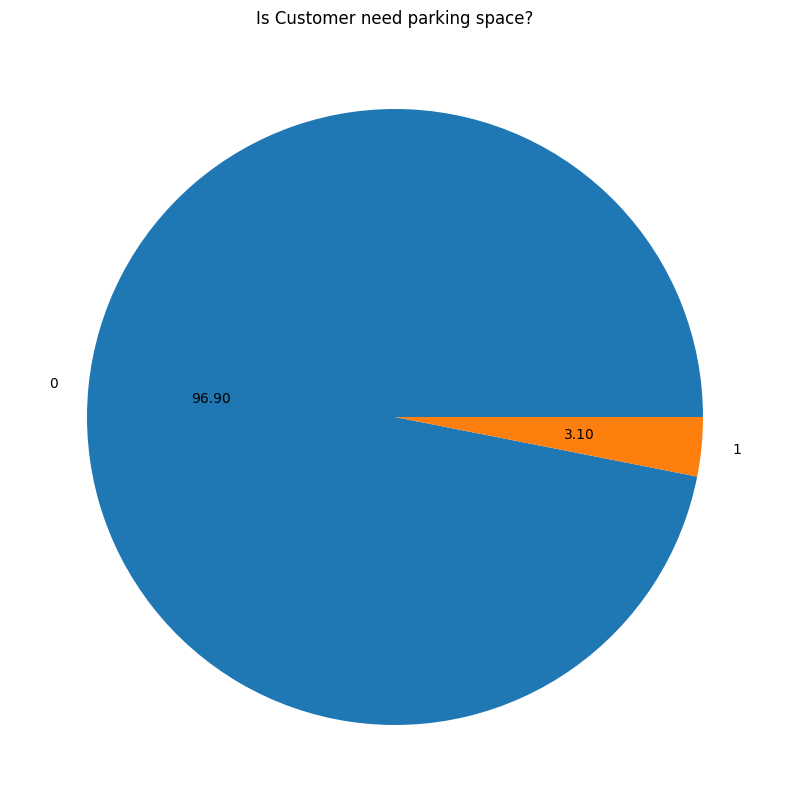

In [15]:
data.groupby('required_car_parking_space')['Booking_ID'].count().plot.pie(y='Booking_ID', autopct='%0.2f', figsize=(10,10), 
    title='Is Customer need parking space?', ylabel='')

Mayoritas customer tidak membutuhkan lahan parkir

<Axes: title={'center': 'What room the customer booked?'}, xlabel='room_type_reserved'>

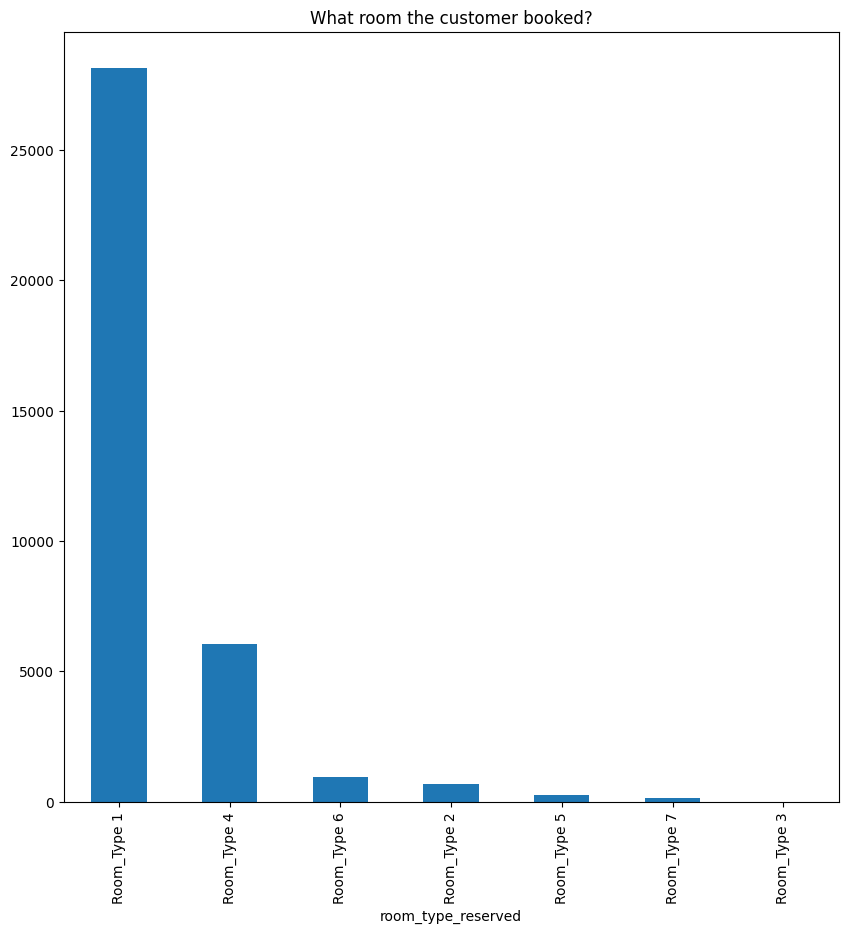

In [16]:
data.groupby('room_type_reserved')['Booking_ID'].count().sort_values(ascending=False).plot.bar(x='room_type_reserved',
    y='booking_status', figsize=(10,10), title='What room the customer booked?')

Customer cenderung memilih tipe room 1 untuk menginap di Liburan Skuy

<Axes: title={'center': 'Which media customer book the hotel from?'}, xlabel='market_segment_type'>

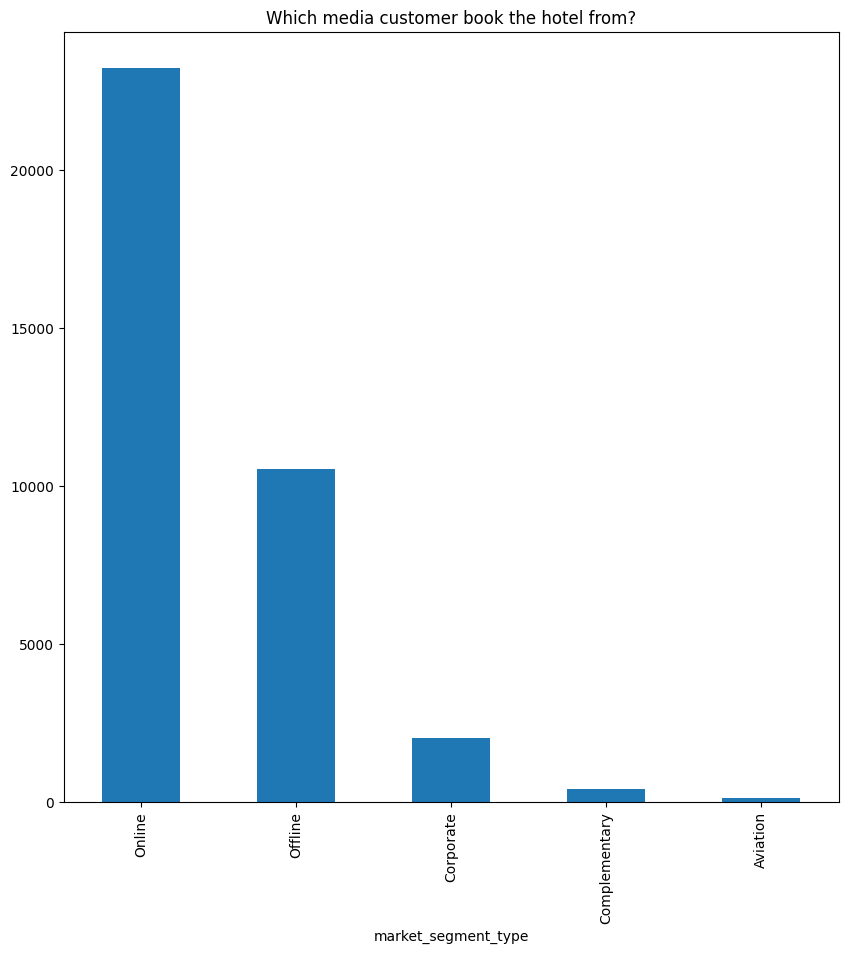

In [17]:
data.groupby('market_segment_type')['Booking_ID'].count().sort_values(ascending=False).plot.bar(x='market_segment_type',
    y='booking_status', figsize=(10,10), title='Which media customer book the hotel from?')

Customer biasanya booking hotel via Online

<Axes: title={'center': 'Is Customer a repeated guest?'}>

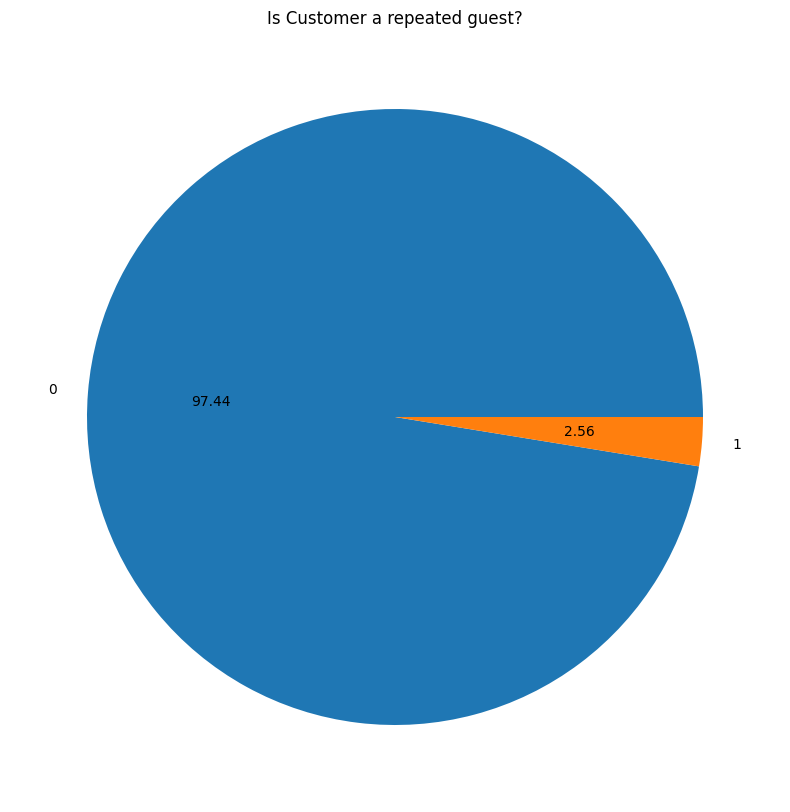

In [18]:
data.groupby('repeated_guest')['Booking_ID'].count().plot.pie(y='Booking_ID', autopct='%0.2f', figsize=(10,10),
    title='Is Customer a repeated guest?',ylabel='')

Kebanyakan customer merupakan pelanggan baru

<Axes: ylabel='booking_status'>

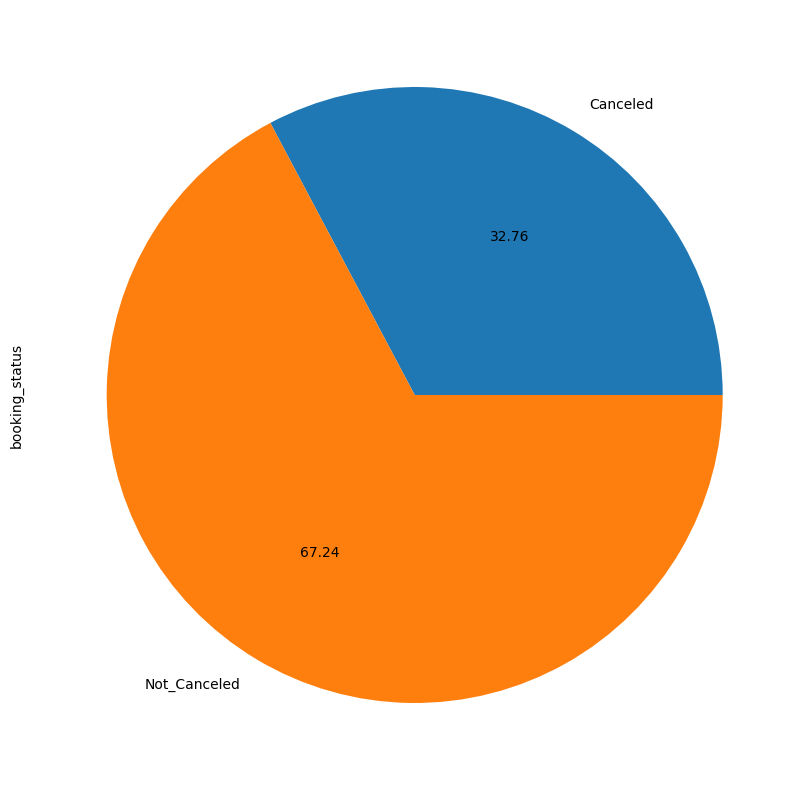

In [19]:
data.groupby('booking_status')['booking_status'].count().plot.pie(y='booking_status', autopct='%0.2f', figsize=(10,10))

Data pada kasus ini sedikit tidak imbang atau **imbalance**. Dikatakan karena data - data dengan order booking di cancel hanya sebanyak **32,76%** saja dari keseluruhan data. Walaupun begitu, tingkat **imbalance** dari datanya tidak ekstrim sehingga tidak perlu melakukan oversampling untuk data kelas minority (Kelas Cancelled)

Skewness of no_of_adults: -0.3332949302307013
Skewness of no_of_children: 4.710349518506961
Skewness of no_of_weekend_nights: 0.7376159576059308
Skewness of no_of_week_nights: 1.5993503651924639
Skewness of lead_time: 1.2924915330710838
Skewness of arrival_year: -1.6696953495540467
Skewness of arrival_month: -0.34822885187738667
Skewness of arrival_date: 0.028808569139449704
Skewness of no_of_previous_cancellations: 25.199875952075615
Skewness of no_of_previous_bookings_not_canceled: 19.250190677395846
Skewness of avg_price_per_room: 0.6671328746979995
Skewness of no_of_special_requests: 1.145080771394943


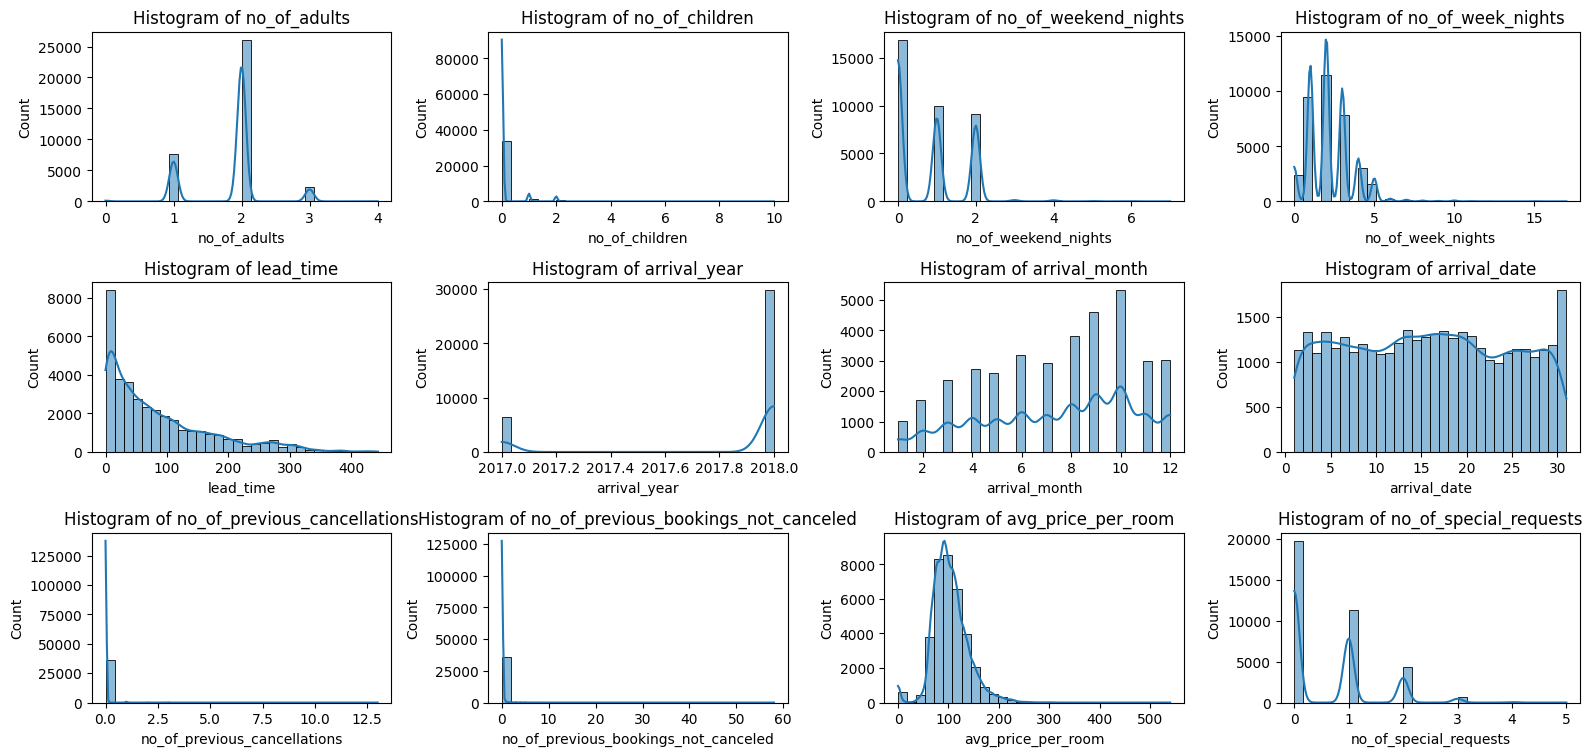

In [20]:
total_col = len(num_col)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in num_col:
    plt.subplot(total_col * 4, 4, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    print(f'Skewness of {col}:',data[col].skew())
    i += 1

plt.tight_layout()
plt.show()

Dari Visualisasi diatas dapat disimpulkan bahwa distribusi dibagi data menjadi 3 yaitu:
- Data **no_of_adults**, **arrival_month** dan **arrival_date** memiliki pemusatan data yang sudah terpusah ke tengah. Walaupun data **no_of_adults** didominasi dengan data yang berada di tengah
- Data **no_of_children**, **no_of_weekends**, **no_of_week_nights**, **lead_time**, **no_of_previous_cancellations**, **no_of_previous_bookings_not_canceled**, **avg_price_per_room**, dan **no_of_special_requests** memiliki distribusi data yang cenderung condong ke kiri.
- Data **arrival_year** memiliki pemusatan data yang condong ke sebelah kanan

Selain itu ada beberapa hal yang bisa disimpulkan:
- Data diambil pada tahun **2017 dan 2018** walaupun lebih banyak order berasal dari tahun **2018**
- Customer yang membooking kamar biasanya terdiri dari **2 orang dewasa**
- Kebanyakan customer melakukan order **tidak memiliki anak**
- Dari analisa sebelumnya kebanyakan customer merupakan customer **baru** sehingga distribusi data **no_of_previous_cancellations** condong ke kiri karena customer yang melakukan order kebanyakan customer baru

Untuk melihat berapa banyaknya outlier akan menggunakan visualisasi boxplot

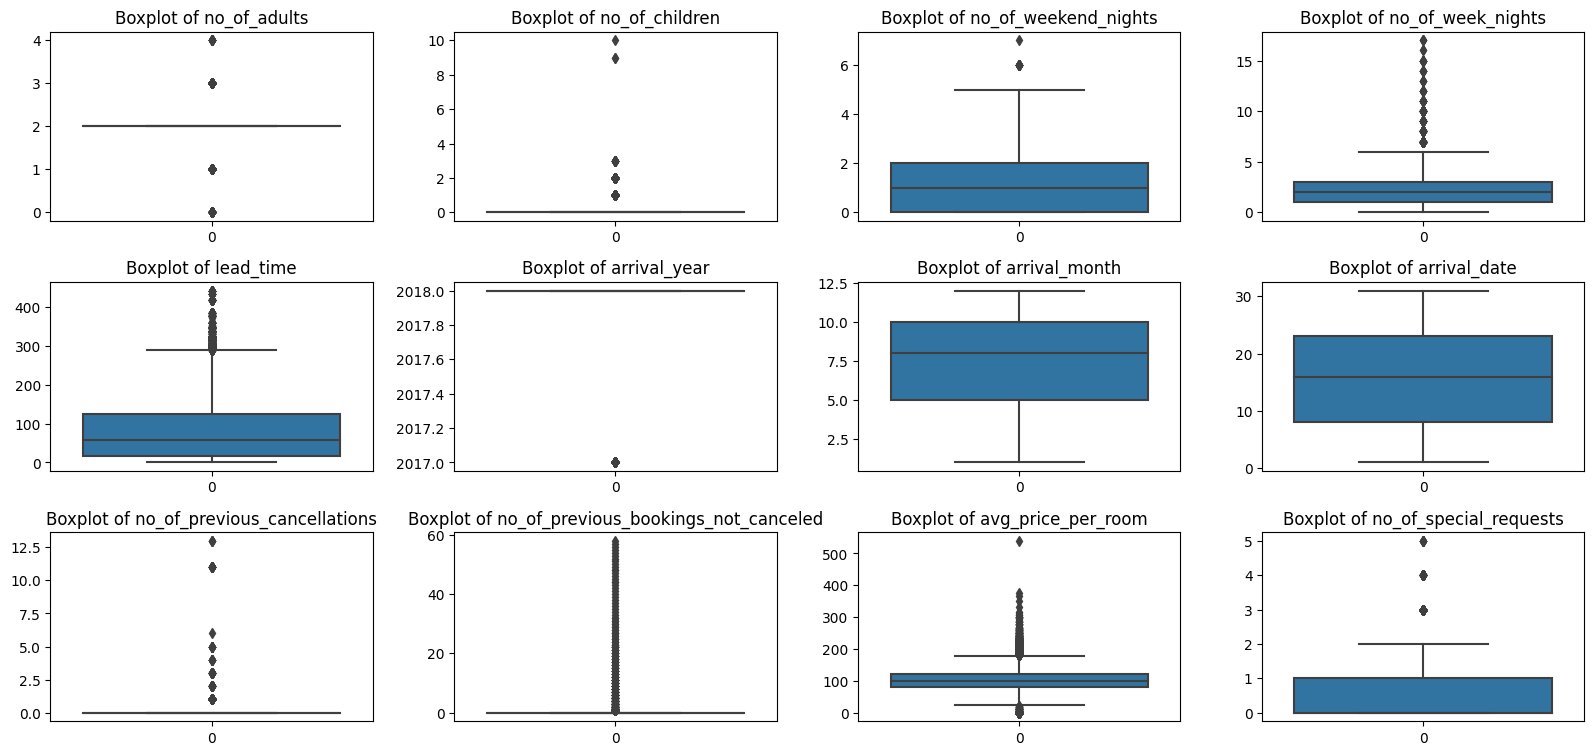

In [21]:
total_col = len(num_col)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in num_col:
    plt.subplot(total_col * 4, 4, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
    i += 1

plt.tight_layout()
plt.show()

Dari visualisasi boxplot, hanya data **arrival_month** dan **arrival_date** yang tidak memiliki outlier. 

In [22]:
label_encode = {'Not_Canceled':0, 'Canceled':1}
data_label = data['booking_status'].replace(label_encode)
data_label = pd.DataFrame(data_label,columns=['booking_status'])

In [23]:
check_corr = pd.concat([data[num_col],data_label],axis=1)

<Axes: >

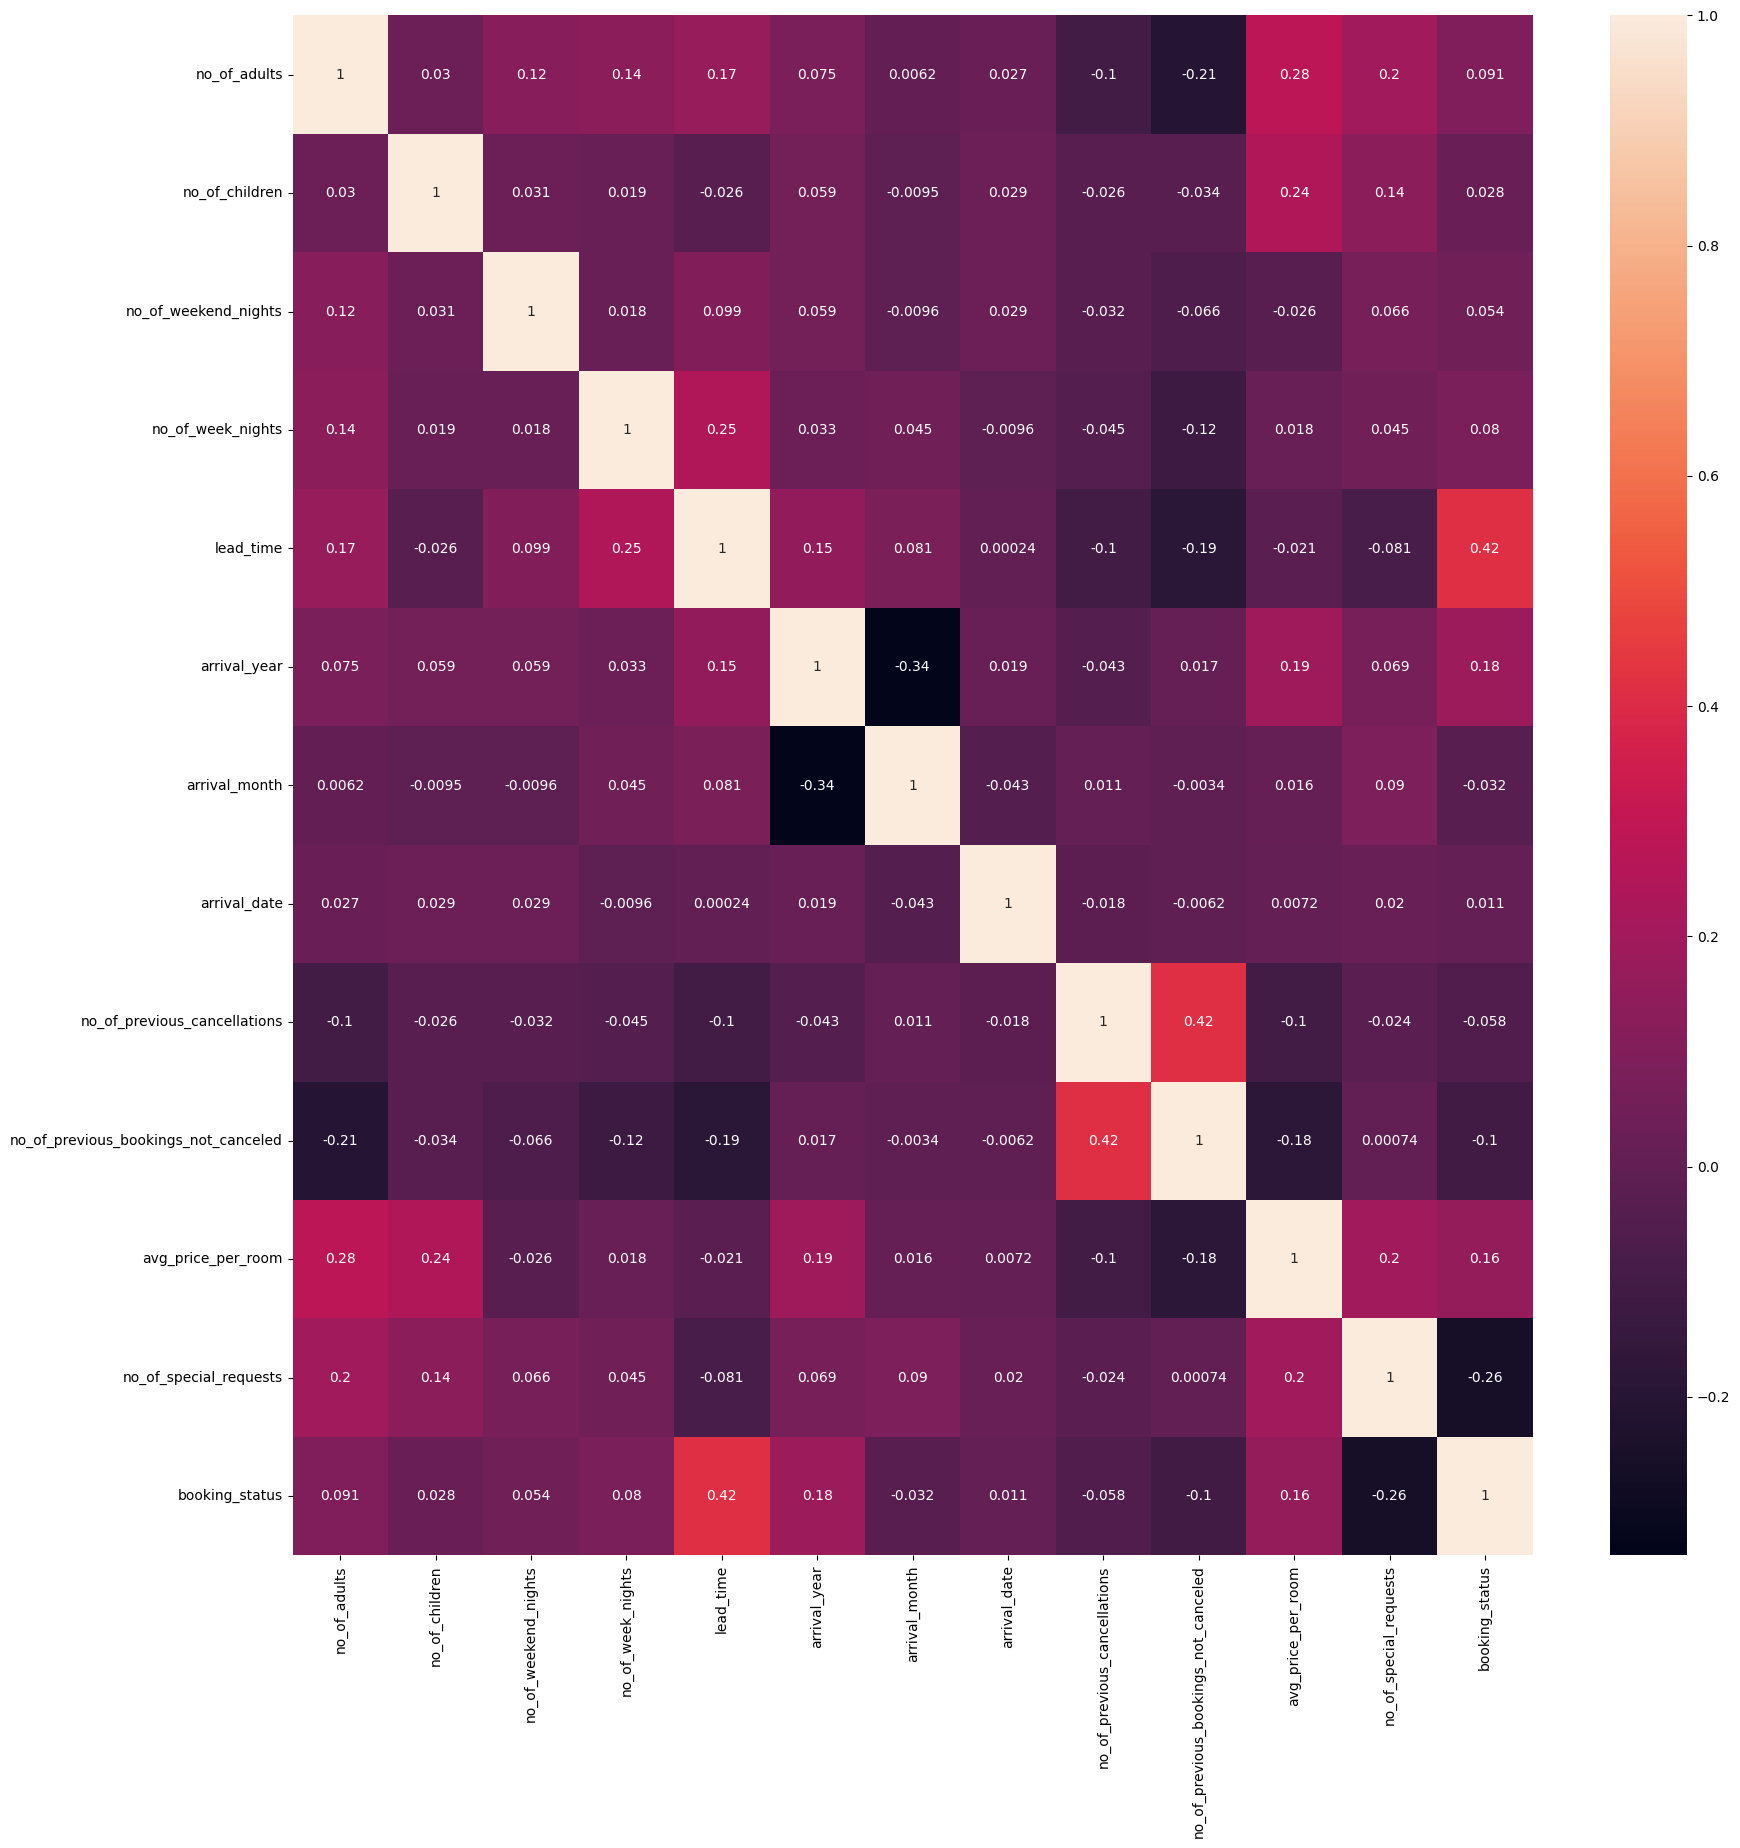

In [24]:
#Membuat heatmap untuk melihat korelasi dengan data numerical dengan data booking_status
plt.figure(figsize=(20,20))
sns.heatmap(check_corr.corr(method='spearman'), annot=True)

Hanya data **lead_time** dan **no_of_special_requests** yang memiliki korelasi atau keterkaitan dengan data **booking_status** dengan nilai korelasi diatas **0.2**. Untuk data category, perlu dilakukan Chi-square test untuk melakukan pengecekan keterhubungan data category dengan data **booking_status**. Dimana p-value yang dibawah 0.05 memiliki keterkaitan yang signifikan dengan data **booking_status**

In [25]:
data_encode = data[cat_col].copy()
encoder = OrdinalEncoder()
data_encode = encoder.fit_transform(data_encode)

In [26]:
chi_scores_cat = chi2(data_encode, data_label)

In [27]:
p_values_cat = pd.Series(chi_scores_cat[1],index = cat_col)
p_values_cat.sort_values(ascending = False , inplace = True)

In [28]:
p_values_cat

room_type_reserved            3.367809e-13
type_of_meal_plan             1.135087e-13
market_segment_type           7.480144e-21
required_car_parking_space    9.888732e-59
repeated_guest                1.790116e-90
dtype: float64

<Axes: >

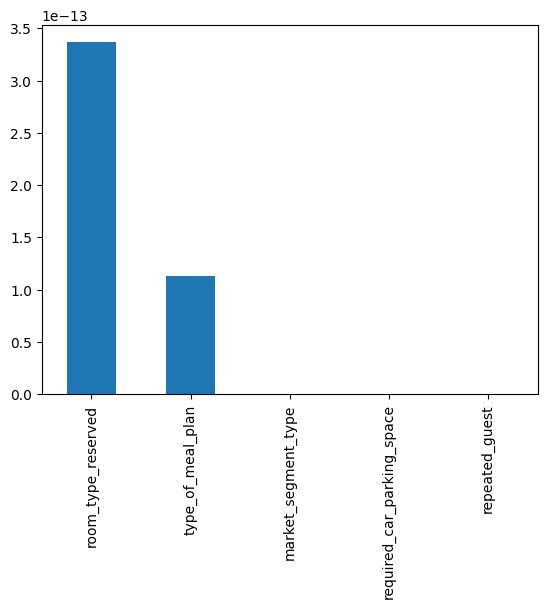

In [29]:
p_values_cat.plot.bar()

Dari hasil analisa dan visualisasi diatas, semua data category signifikan berhubungan dengan data **booking_status**. Dimana data yang digunakan berasal dari data numerical yang korelasinya diatas **0.2** yaitu data **lead_time** dan **no_of_special_requests** serta data - data categorical

# Feature Engineering

## Split X and y between Train-set and Test-set

Melakukan split pada data X dan y. Dimana data X merupakan data dependen sedangkan data y merupakan data target. Dalam kasus ini data targetnya ialah **booking_status**

In [30]:
#Split x dan y
X = data.drop(['booking_status'], axis=1)
y = data['booking_status']
X

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)
X_train

Train Size :  (29020, 18)
Test Size :  (7255, 18)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
7822,INN07823,2,0,2,0,Meal Plan 1,0,Room_Type 1,67,2018,3,13,Online,0,0,0,78.30,0
2304,INN02305,1,0,0,2,Meal Plan 1,0,Room_Type 1,172,2018,6,24,Online,0,0,0,95.00,0
15511,INN15512,1,0,1,0,Meal Plan 1,0,Room_Type 1,0,2018,6,20,Corporate,0,0,0,95.00,0
18835,INN18836,2,0,0,3,Meal Plan 1,0,Room_Type 1,77,2017,11,12,Online,0,0,0,72.25,1
28549,INN28550,2,0,0,2,Meal Plan 2,0,Room_Type 1,74,2017,9,18,Offline,0,0,0,109.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,INN03661,2,0,0,2,Meal Plan 1,0,Room_Type 1,29,2018,12,2,Corporate,0,0,0,85.00,0
25938,INN25939,2,0,2,3,Meal Plan 1,0,Room_Type 1,102,2018,11,17,Online,0,0,0,85.00,2
8380,INN08381,2,1,0,3,Meal Plan 1,0,Room_Type 1,15,2018,3,24,Online,0,0,0,165.67,2
31267,INN31268,2,0,0,1,Not Selected,0,Room_Type 1,32,2018,8,20,Online,0,0,0,96.33,1


## Handle Missing Value

Tidak ada missing value pada dataset ini

## Handle Outlier

Melakukan pengecekan pada outlier.

In [32]:
#Fungsi untuk mendapatkan upper limit dan lower limit
def find_limit(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_limit = df[variable].quantile(0.25) - (IQR * distance)
    upper_limit  = df[variable].quantile(0.75) + (IQR * distance)

    return upper_limit, lower_limit

In [33]:
outlier_check = num_col
data_outlier_check = {}
for i in outlier_check:
        data_outlier_check[f'{i}_upper_limit'], data_outlier_check[f'{i}_lower_limit'] = find_limit(X_train, i, 1.5)

In [34]:
print('Full data:', X_train.shape)
for i in outlier_check:
    print(f'Data without {i} outlier:',
        X_train[(X_train[i] >= data_outlier_check[f'{i}_lower_limit']) & (X_train[i] <= data_outlier_check[f'{i}_upper_limit'])].shape)
    print(f'Percent outlier for {i}:',
        len(X_train[(X_train[i] < data_outlier_check[f'{i}_lower_limit']) | (X_train[i] > data_outlier_check[f'{i}_upper_limit'])]) / len(X_train) * 100)

Full data: (29020, 18)
Data without no_of_adults outlier: (20914, 18)
Percent outlier for no_of_adults: 27.93246037215713
Data without no_of_children outlier: (26886, 18)
Percent outlier for no_of_children: 7.3535492763611305
Data without no_of_weekend_nights outlier: (29005, 18)
Percent outlier for no_of_weekend_nights: 0.05168849069607167
Data without no_of_week_nights outlier: (28762, 18)
Percent outlier for no_of_week_nights: 0.8890420399724328
Data without lead_time outlier: (27943, 18)
Percent outlier for lead_time: 3.7112336319779464
Data without arrival_year outlier: (23794, 18)
Percent outlier for arrival_year: 18.008270158511372
Data without arrival_month outlier: (29020, 18)
Percent outlier for arrival_month: 0.0
Data without arrival_date outlier: (29020, 18)
Percent outlier for arrival_date: 0.0
Data without no_of_previous_cancellations outlier: (28758, 18)
Percent outlier for no_of_previous_cancellations: 0.9028256374913852
Data without no_of_previous_bookings_not_canceled

Setelah melihat jumlah outlier yang ada, data outlier sebaiknya di handle dengan menggunakan metode **capping** untuk data **lead_time** dan data **no_of_special_requests**. Karena kedua data tersebut memiliki hubungan yang signifikan dengan data **booking_status**. Untuk data lainnya akan di drop columnya karena data tersebut tidak memiliki hubungan signifikan dengan data **booking_status**

In [35]:
winsorizer = Winsorizer(capping_method='iqr', # gaussian for mean and std
                          tail='both', # cap both tails 
                          fold=1.5, # Menggunakan fold 1.5 karena outlier pada capital_gain dan capital_loss cukup ekstrim
                          variables=['lead_time','no_of_special_requests'])

winsorizer.fit(X_train)
X_train = winsorizer.transform(X_train)
X_test = winsorizer.transform(X_test)

Skew of lead_time: 1.0765997920968349
Skew of no_of_special_requests: 0.8757311788940123


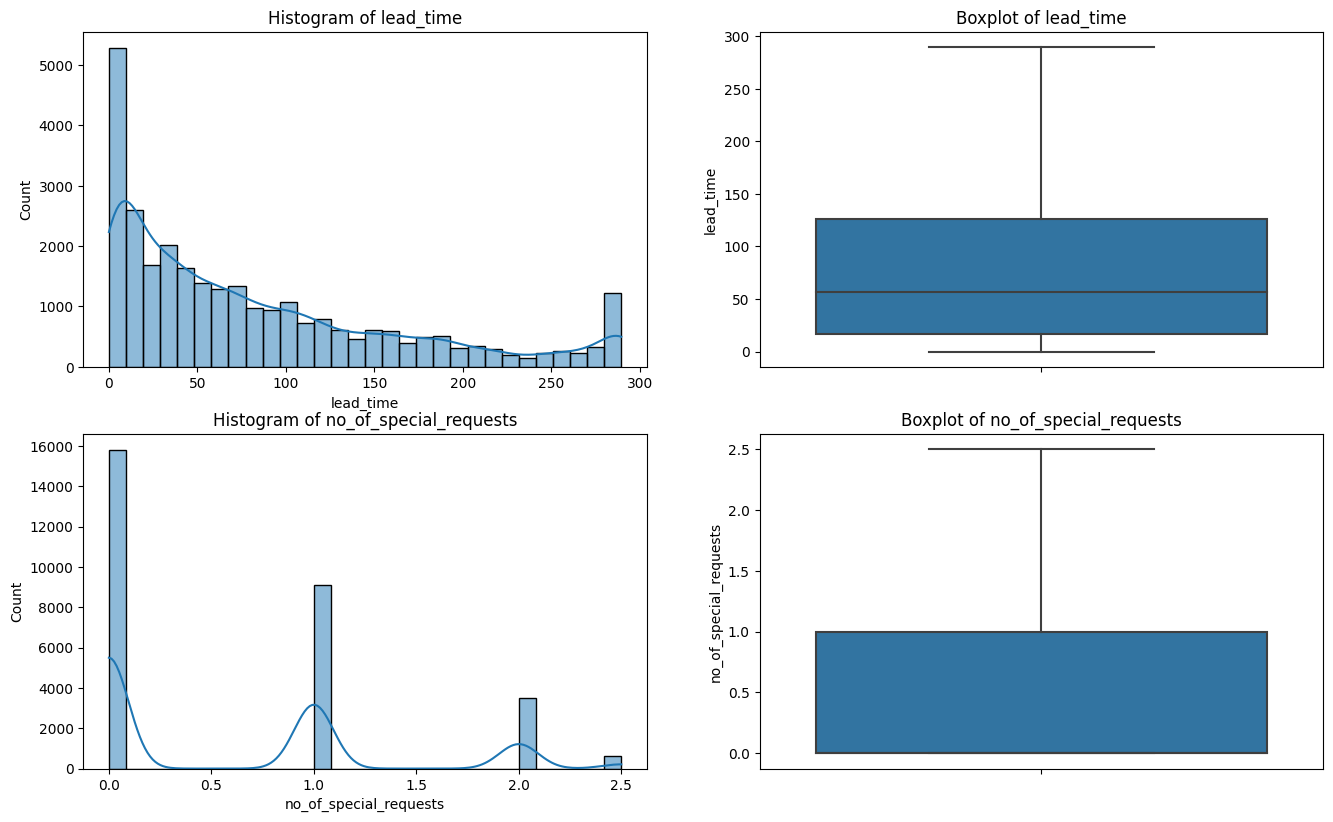

In [36]:
check_1 = ['lead_time','no_of_special_requests']
total_col = len(check_1)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in check_1:
    plt.subplot(total_col * 2, 2, i)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    i += 1

    plt.subplot(total_col * 2, 2, i)
    sns.boxplot(y=X_train[col])
    plt.title(f'Boxplot of {col}')
    print(f'Skew of {col}:',X_train[col].skew())
    i += 1

plt.show()

Data **lead_time** dan **no_of_special_requests** memiliki data yang masih cenderung ke kiri setelah dihandle outliernya meskipun kedua data tersebut sudah tidak memiliki outlier

## Make Pipeline for Features

Dari hasil analisa diatas hanya data **lead_time**, **no_of_special_requests**, serta data - data categorical yang memiliki keterkaitan dengan data **booking_status** sehingga selain data yang disebutkan akan di drop pada pipeline features ini

### Split Category and Numerical Columns

In [37]:
num_cols = ['lead_time', 'no_of_special_requests']
cat_cols = cat_col

Melihat summary pada data X_train

In [38]:
X_train.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000
mean,1.845245,0.104273,0.811785,2.201826,0.031116,83.705910,2017.819917,7.433012,15.635768,0.025569,0.021709,0.149862,103.411871,0.606513
std,0.517784,0.400062,0.869792,1.406062,0.173635,81.816865,0.384263,3.067561,8.730608,0.157847,0.345616,1.727751,35.186129,0.746490
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,1.000000,289.500000,2018.000000,12.000000,31.000000,1.000000,13.000000,57.000000,540.000000,2.500000


Setelah melihat summary pada data X_train, dapat dilihat bahwa range data pada setiap columnya sangat beragam sehingga perlu dilakukan scaling. Selain itu, data category juga perlu di encode. Oleh karena itu mari buat pipeline khusus preprocess data (Scaling dan Encode)

### Feature Scaling

In [39]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", MinMaxScaler())
    ]
)

### Feature Encoding

In [40]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder()),
    ]
)

In [41]:
label_encode = {'Not_Canceled':0, 'Canceled':1}
y_train = y_train.replace(label_encode)
y_test = y_test.replace(label_encode)

### Concat the preprocessor

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# Model Definition

Pada kesempatan ini, model yang digunakan ada 7 yaitu model **Logistic Regression**, **SVM**, **KNN**, **Naive Bayes**, **Decision Tree**, **Random Forest**, dan **XGBoost**. Nantinya 3 model dengan performa terbaik pada base modelnya akan di tuning lagi, lalu model terbaik setelah dituning akan disimpan untuk melakukan prediksi pembatalan kartu kredit di bulan depannya

In [43]:
log_reg = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])

In [44]:
svm_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", SVC())])

In [45]:
knn_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())])

In [46]:
nb_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", GaussianNB())])

In [47]:
dt_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())])

In [48]:
rf_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())])

In [49]:
xgb_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", xgb.XGBClassifier())])

# Model Training

## Cross Validation

Selama cross validation, metric yang digunakan adalah recall dari label 1 (Canceled)

In [50]:
# Dict for report
all_reports = {}

In [51]:
recall_train_cross_val = cross_val_score(log_reg, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - Logistic Regression  : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - Logistic Regression : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - Logistic Regression  : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - Logistic Regression  : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['Logistic Regression (Baseline)'] = score_reports


Recall - All - Cross Validation  - Logistic Regression  :  [0.56496581 0.58127301 0.57728707 0.53364879 0.56309148]
Recall - Mean - Cross Validation - Logistic Regression :  0.564053232263057
Recall - Std - Cross Validation  - Logistic Regression  :  0.016720305449994935
Recall - Range of Test-Set       - Logistic Regression  :  0.5473329268130621 - 0.580773537713052


In [52]:
recall_train_cross_val = cross_val_score(svm_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - SVM : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - SVM : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - SVM : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - SVM : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['SVM (Baseline)'] = score_reports

Recall - All - Cross Validation  - SVM :  [0.55181483 0.56654392 0.56887487 0.52365931 0.54416404]
Recall - Mean - Cross Validation - SVM :  0.5510113941912248
Recall - Std - Cross Validation  - SVM :  0.016468343815387424
Recall - Range of Test-Set       - SVM :  0.5345430503758374 - 0.5674797380066122


In [53]:
recall_train_cross_val = cross_val_score(knn_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - KNN : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - KNN : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - KNN : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - KNN : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['KNN (Baseline)'] = score_reports

Recall - All - Cross Validation  - KNN :  [0.68805892 0.69068911 0.6997897  0.68611987 0.70347003]
Recall - Mean - Cross Validation - KNN :  0.6936255255549268
Recall - Std - Cross Validation  - KNN :  0.00679493576537402
Recall - Range of Test-Set       - KNN :  0.6868305897895528 - 0.7004204613203009


In [54]:
recall_train_cross_val = cross_val_score(nb_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - Naive Bayes : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - Naive Bayes : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - Naive Bayes : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - Naive Bayes : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['Naive Bayes (Baseline)'] = score_reports

Recall - All - Cross Validation  - Naive Bayes :  [0.95055234 0.95423461 0.95688749 0.94479495 0.9553102 ]
Recall - Mean - Cross Validation - Naive Bayes :  0.9523559187123274
Recall - Std - Cross Validation  - Naive Bayes :  0.004317718852622084
Recall - Range of Test-Set       - Naive Bayes :  0.9480381998597053 - 0.9566736375649495


In [55]:
recall_train_cross_val = cross_val_score(dt_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - Decision Tree : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - Decision Tree : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - Decision Tree : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - Decision Tree : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['Decision Tree (Baseline)'] = score_reports

Recall - All - Cross Validation  - Decision Tree :  [0.6459758  0.6649132  0.66298633 0.67350158 0.68664564]
Recall - Mean - Cross Validation - Decision Tree :  0.6668045098849408
Recall - Std - Cross Validation  - Decision Tree :  0.013345498142812532
Recall - Range of Test-Set       - Decision Tree :  0.6534590117421283 - 0.6801500080277533


In [56]:
recall_train_cross_val = cross_val_score(rf_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - Random Forest : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - Random Forest : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - Random Forest : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - Random Forest : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['Random Forest (Baseline)'] = score_reports

Recall - All - Cross Validation  - Random Forest :  [0.67385587 0.69542346 0.69610936 0.69768665 0.70715037]
Recall - Mean - Cross Validation - Random Forest :  0.6940451397819843
Recall - Std - Cross Validation  - Random Forest :  0.010943264089476063
Recall - Range of Test-Set       - Random Forest :  0.6831018756925082 - 0.7049884038714604


In [57]:
recall_train_cross_val = cross_val_score(xgb_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='recall')

print('Recall - All - Cross Validation  - XGBoost : ', recall_train_cross_val)
print('Recall - Mean - Cross Validation - XGBoost : ', recall_train_cross_val.mean())
print('Recall - Std - Cross Validation  - XGBoost : ', recall_train_cross_val.std())
print('Recall - Range of Test-Set       - XGBoost : ', (recall_train_cross_val.mean()-recall_train_cross_val.std()) , '-', (recall_train_cross_val.mean()+recall_train_cross_val.std()))

score_reports = {
    'Recall - All - Cross Validation': recall_train_cross_val,
    'Recall - Mean - Cross Validation': recall_train_cross_val.mean(),
    'Recall - Std - Cross Validation': recall_train_cross_val.std(),
    'Recall - Range of Test-Set': str((recall_train_cross_val.mean()-recall_train_cross_val.std())) + '-' + str((recall_train_cross_val.mean()+recall_train_cross_val.std()))
}
all_reports['XGBoost (Baseline)'] = score_reports

Recall - All - Cross Validation  - XGBoost :  [0.71330878 0.7175171  0.71766562 0.71713985 0.70925342]
Recall - Mean - Cross Validation - XGBoost :  0.7149769532998018
Recall - Std - Cross Validation  - XGBoost :  0.0032833218397011923
Recall - Range of Test-Set       - XGBoost :  0.7116936314601007 - 0.718260275139503


In [58]:
pd.DataFrame(all_reports).T

,Recall - All - Cross Validation,Recall - Mean - Cross Validation,Recall - Std - Cross Validation,Recall - Range of Test-Set
Logistic Regression (Baseline),"[0.5649658074697528, 0.581273014203051, 0.5772...",0.564053,0.01672,0.5473329268130621-0.580773537713052
SVM (Baseline),"[0.551814834297738, 0.5665439242503946, 0.5688...",0.551011,0.016468,0.5345430503758374-0.5674797380066122
KNN (Baseline),"[0.6880589163598106, 0.6906891109942136, 0.699...",0.693626,0.006795,0.6868305897895528-0.7004204613203009
Naive Bayes (Baseline),"[0.9505523408732246, 0.9542346133613887, 0.956...",0.952356,0.004318,0.9480381998597053-0.9566736375649495
Decision Tree (Baseline),"[0.6459758022093635, 0.6649132035770647, 0.662...",0.666805,0.013345,0.6534590117421283-0.6801500080277533
Random Forest (Baseline),"[0.6738558653340347, 0.6954234613361389, 0.696...",0.694045,0.010943,0.6831018756925082-0.7049884038714604
XGBoost (Baseline),"[0.7133087848500789, 0.7175170962651236, 0.717...",0.714977,0.003283,0.7116936314601007-0.718260275139503


Dari hasil valisadi silang, tiga model yang memiliki performa terbaik adalah **Naive Bayes**, **XGBoost**, dan **Random Forest** dengan rata - rata recall pada label 1 selama validasi silang sebesar **95,23%** , **71,49%**, dan **69,404%**

## Baseline Model

In [59]:
nb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lead_time',
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest'])])),
                ('classifier', GaussianNB())])

In [60]:
xgb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lead_time',
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest'])])),
                ('classifier',
                 XGBClassifie...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [61]:
rf_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lead_time',
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest'])])),
                ('classifier', RandomForestClassifier())])

## Hyperparameter Tuning

### Naive Bayes

In [62]:
param_nb = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}
nb_grid = GridSearchCV(estimator=nb_model,
                         param_grid=param_nb,
                         cv=5,
                         n_jobs=-1,
                         verbose=2, 
                         scoring='recall')

nb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['lead_time',
                                                                          'no_of_special_requests']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['type_of_meal_plan',
                                                                          'required_car_parking_space',
                                                                          'room_type_reserved',
                                                                          'market_segment_type',
                                                                          'repeated_guest'])])...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='recall', verbose=2)

In [63]:
nb_grid.best_params_

{'classifier__var_smoothing': 2.848035868435799e-05}

### XGBoost

In [64]:
params = {
        'classifier__min_child_weight': [2, 3, 4, 5, 6],
        'classifier__gamma': [3, 3.5, 4, 4.5, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1],
        'classifier__max_depth': [9]
}

xgb_grid = GridSearchCV(estimator=xgb_model, 
                                 param_grid=params,
                                 cv=5, 
                                 n_jobs=-1, 
                                 verbose = 2,
                                 scoring='recall')

xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['lead_time',
                                                                          'no_of_special_requests']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['type_of_meal_plan',
                                                                          'required_car_parking_space',
                                                                          'room_type_reserved',
                                                                          'market_segment_type',
                                                                          'repeated_guest'])])...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 0.9, 1],
                         'classifier__gamma': [3, 3.5, 4, 4.5, 5],
                         'classifier__max_depth': [9],
                         'classifier__min_child_weight': [2, 3, 4, 5, 6],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='recall', verbose=2)

In [65]:
xgb_grid.best_params_

{'classifier__colsample_bytree': 0.9,
 'classifier__gamma': 4.5,
 'classifier__max_depth': 9,
 'classifier__min_child_weight': 4,
 'classifier__subsample': 1.0}

### Random Forest

In [66]:
n_estimators = [1200,1300,1400,1500,1600]
max_features = ['auto']
max_depth = [890]
min_samples_split = [8,9,10,11,12]
min_samples_leaf = [2]
param_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features':max_features,
               'classifier__max_depth':max_depth,
               'classifier__min_samples_split':min_samples_split,
               'classifier__min_samples_leaf':min_samples_leaf,
               'classifier__criterion':['gini']}

rf_grid = GridSearchCV(estimator=rf_model,
                         param_grid=param_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=2, 
                         scoring='recall')
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\Evaldo Raynardi\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['lead_time',
                                                                          'no_of_special_requests']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['type_of_meal_plan',
                                                                          'required_car_parking_space',
                                                                          'room_type_reserved',
                                                                          'market_segment_type',
                                                                          'repeated_guest'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini'],
                         'classifier__max_depth': [890],
                         'classifier__max_features': ['auto'],
                         'classifier__min_samples_leaf': [2],
                         'classifier__min_samples_split': [8, 9, 10, 11, 12],
                         'classifier__n_estimators': [1200, 1300, 1400, 1500,
                                                      1600]},
             scoring='recall', verbose=2)

In [67]:
rf_grid.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 890,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 11,
 'classifier__n_estimators': 1300}

# Model Evaluation

Setelah melakukan training mari di evaluasi seberapa tepat prediksi dari model yang sudah di training, baik dari baseline parameter maupun setelah hyperparameter tuning

In [68]:
all_reports = {}

### Naive Bayes

#### Baseline

In [69]:
y_pred_train = nb_model.predict(X_train)
y_pred_test = nb_model.predict(X_test)

Accuracy Score - Train: 51.050999310820124
Accuracy Score - Test: 51.274982770503094
Recall for label 0 - Train: 29.49979499794998
Recall for label 0 - Test: 29.766297662976633
Recall for label 1 - Train: 95.27766091712242
Recall for label 1 - Test: 95.41438788388726
Average of Recall - Train: 62.3887279575362
Average of Recall - Test: 62.59034277343194
Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.30      0.45      4878
           1       0.40      0.95      0.56      2377

    accuracy                           0.51      7255
   macro avg       0.66      0.63      0.51      7255
weighted avg       0.76      0.51      0.49      7255
 

Confusion Matrix      : 


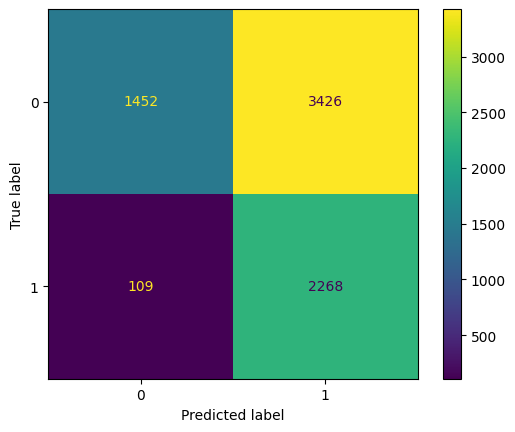

In [70]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
recall_total_train = 0
recall_total_test = 0
for i in y_train.unique():
    print(f'Recall for label {i} - Train:', recall_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'Recall for label {i} - Test:', recall_score(y_test, y_pred_test, pos_label=i) * 100)
    recall_total_train += recall_score(y_train, y_pred_train, pos_label=i) * 100
    recall_total_test += recall_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of Recall - Train:', recall_total_train/len(y_train.unique()))
print('Average of Recall - Test:', recall_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())
score_reports = {
    'Accuracy - Train': accuracy_score(y_train, y_pred_train) * 100,
    'Recall for Not Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=0) * 100,
    'Recall for Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=1) * 100,
    'Average of Recall - Train': recall_total_train/len(y_train.unique()),
    'Accuracy - Test': accuracy_score(y_test, y_pred_test) * 100,
    'Recall for Not Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=0) * 100,
    'Recall for Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=1) * 100,
    'Average of Recall - Test': recall_total_test/len(y_train.unique()),
}
all_reports['Naive Bayes (Baselined)'] = score_reports

#### Hyperparameter Tuned

In [71]:
y_pred_train = nb_grid.predict(X_train)
y_pred_test = nb_grid.predict(X_test)

Accuracy Score - Train: 51.206064782908335
Accuracy Score - Test: 51.34390075809786
Recall for label 0 - Train: 29.745797457974582
Recall for label 0 - Test: 29.86879868798688
Recall for label 1 - Train: 95.24610854017669
Recall for label 1 - Test: 95.41438788388726
Average of Recall - Train: 62.49595299907564
Average of Recall - Test: 62.64159328593707
Classification Report : 
               precision    recall  f1-score   support

           0       0.93      0.30      0.45      4878
           1       0.40      0.95      0.56      2377

    accuracy                           0.51      7255
   macro avg       0.66      0.63      0.51      7255
weighted avg       0.76      0.51      0.49      7255
 

Confusion Matrix      : 


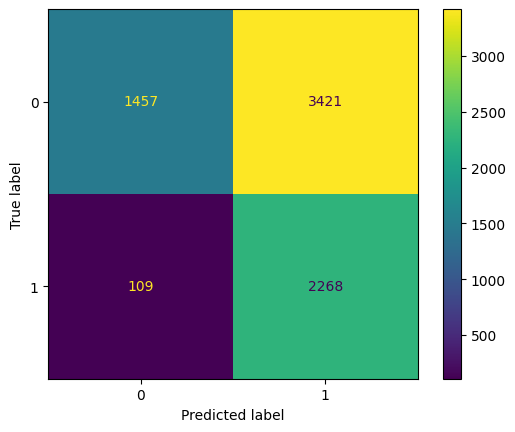

In [72]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
recall_total_train = 0
recall_total_test = 0
for i in y_train.unique():
    print(f'Recall for label {i} - Train:', recall_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'Recall for label {i} - Test:', recall_score(y_test, y_pred_test, pos_label=i) * 100)
    recall_total_train += recall_score(y_train, y_pred_train, pos_label=i) * 100
    recall_total_test += recall_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of Recall - Train:', recall_total_train/len(y_train.unique()))
print('Average of Recall - Test:', recall_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())
score_reports = {
    'Accuracy - Train': accuracy_score(y_train, y_pred_train) * 100,
    'Recall for Not Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=0) * 100,
    'Recall for Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=1) * 100,
    'Average of Recall - Train': recall_total_train/len(y_train.unique()),
    'Accuracy - Test': accuracy_score(y_test, y_pred_test) * 100,
    'Recall for Not Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=0) * 100,
    'Recall for Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=1) * 100,
    'Average of Recall - Test': recall_total_test/len(y_train.unique()),
}
all_reports['Naive Bayes (Tuned)'] = score_reports

### XGBoost

#### Baseline

In [73]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

Accuracy Score - Train: 84.80013783597519
Accuracy Score - Test: 83.92832529290145
Recall for label 0 - Train: 90.45715457154571
Recall for label 0 - Test: 89.44239442394424
Recall for label 1 - Train: 73.19099705511148
Recall for label 1 - Test: 72.61253681110644
Average of Recall - Train: 81.82407581332859
Average of Recall - Test: 81.02746561752534
Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      4878
           1       0.77      0.73      0.75      2377

    accuracy                           0.84      7255
   macro avg       0.82      0.81      0.81      7255
weighted avg       0.84      0.84      0.84      7255
 

Confusion Matrix      : 


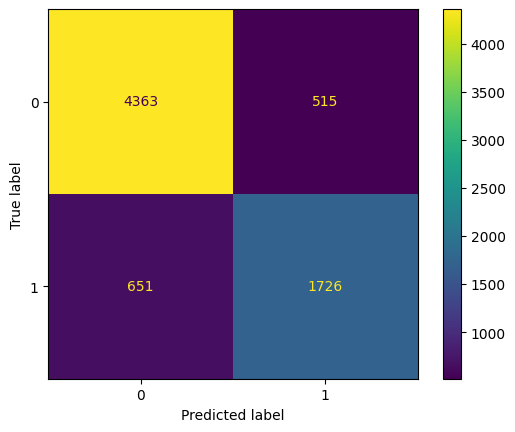

In [74]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
recall_total_train = 0
recall_total_test = 0
for i in y_train.unique():
    print(f'Recall for label {i} - Train:', recall_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'Recall for label {i} - Test:', recall_score(y_test, y_pred_test, pos_label=i) * 100)
    recall_total_train += recall_score(y_train, y_pred_train, pos_label=i) * 100
    recall_total_test += recall_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of Recall - Train:', recall_total_train/len(y_train.unique()))
print('Average of Recall - Test:', recall_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())
score_reports = {
    'Accuracy - Train': accuracy_score(y_train, y_pred_train) * 100,
    'Recall for Not Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=0) * 100,
    'Recall for Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=1) * 100,
    'Average of Recall - Train': recall_total_train/len(y_train.unique()),
    'Accuracy - Test': accuracy_score(y_test, y_pred_test) * 100,
    'Recall for Not Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=0) * 100,
    'Recall for Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=1) * 100,
    'Average of Recall - Test': recall_total_test/len(y_train.unique()),
}
all_reports['XGBoost (Baselined)'] = score_reports

#### Hyperparameter Tuned

In [75]:
y_pred_train = xgb_grid.predict(X_train)
y_pred_test = xgb_grid.predict(X_test)

Accuracy Score - Train: 83.9248793935217
Accuracy Score - Test: 83.28049620951067
Recall for label 0 - Train: 89.10926609266092
Recall for label 0 - Test: 88.21238212382124
Recall for label 1 - Train: 73.28565418594867
Recall for label 1 - Test: 73.15944467816576
Average of Recall - Train: 81.1974601393048
Average of Recall - Test: 80.6859134009935
Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      4878
           1       0.75      0.73      0.74      2377

    accuracy                           0.83      7255
   macro avg       0.81      0.81      0.81      7255
weighted avg       0.83      0.83      0.83      7255
 

Confusion Matrix      : 


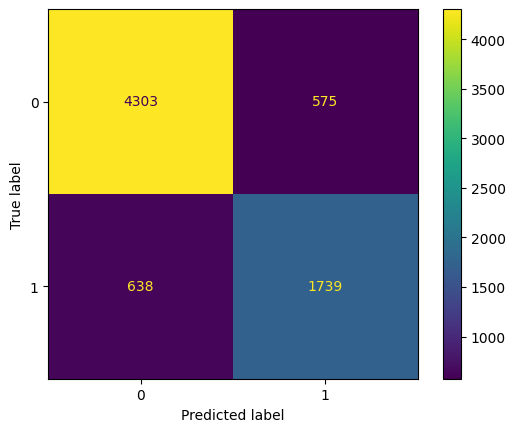

In [76]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
recall_total_train = 0
recall_total_test = 0
for i in y_train.unique():
    print(f'Recall for label {i} - Train:', recall_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'Recall for label {i} - Test:', recall_score(y_test, y_pred_test, pos_label=i) * 100)
    recall_total_train += recall_score(y_train, y_pred_train, pos_label=i) * 100
    recall_total_test += recall_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of Recall - Train:', recall_total_train/len(y_train.unique()))
print('Average of Recall - Test:', recall_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())
score_reports = {
    'Accuracy - Train': accuracy_score(y_train, y_pred_train) * 100,
    'Recall for Not Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=0) * 100,
    'Recall for Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=1) * 100,
    'Average of Recall - Train': recall_total_train/len(y_train.unique()),
    'Accuracy - Test': accuracy_score(y_test, y_pred_test) * 100,
    'Recall for Not Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=0) * 100,
    'Recall for Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=1) * 100,
    'Average of Recall - Test': recall_total_test/len(y_train.unique()),
}
all_reports['XGBoost (Tuned)'] = score_reports

### Random Forest

#### Baseline

In [77]:
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

Accuracy Score - Train: 86.78497587870434
Accuracy Score - Test: 82.82563749138525
Recall for label 0 - Train: 92.16892168921689
Recall for label 0 - Test: 88.92988929889299
Recall for label 1 - Train: 75.7362221287337
Recall for label 1 - Test: 70.29869583508625
Average of Recall - Train: 83.9525719089753
Average of Recall - Test: 79.61429256698962
Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      4878
           1       0.76      0.70      0.73      2377

    accuracy                           0.83      7255
   macro avg       0.81      0.80      0.80      7255
weighted avg       0.83      0.83      0.83      7255
 

Confusion Matrix      : 


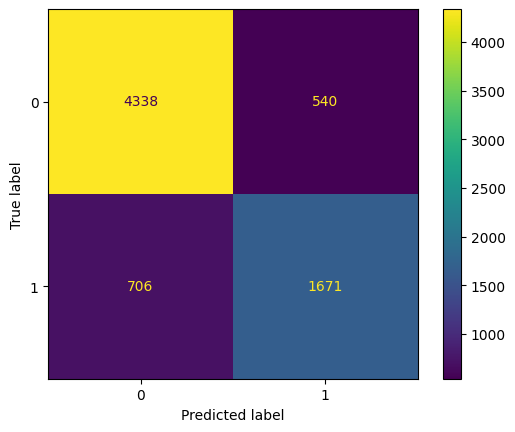

In [78]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
recall_total_train = 0
recall_total_test = 0
for i in y_train.unique():
    print(f'Recall for label {i} - Train:', recall_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'Recall for label {i} - Test:', recall_score(y_test, y_pred_test, pos_label=i) * 100)
    recall_total_train += recall_score(y_train, y_pred_train, pos_label=i) * 100
    recall_total_test += recall_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of Recall - Train:', recall_total_train/len(y_train.unique()))
print('Average of Recall - Test:', recall_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())
score_reports = {
    'Accuracy - Train': accuracy_score(y_train, y_pred_train) * 100,
    'Recall for Not Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=0) * 100,
    'Recall for Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=1) * 100,
    'Average of Recall - Train': recall_total_train/len(y_train.unique()),
    'Accuracy - Test': accuracy_score(y_test, y_pred_test) * 100,
    'Recall for Not Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=0) * 100,
    'Recall for Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=1) * 100,
    'Average of Recall - Test': recall_total_test/len(y_train.unique()),
}
all_reports['Random Forest (Baseline)'] = score_reports

#### Hyperparameter Tuned

In [79]:
y_pred_train = rf_grid.predict(X_train)
y_pred_test = rf_grid.predict(X_test)

Accuracy Score - Train: 85.6685044796692
Accuracy Score - Test: 83.58373535492764
Recall for label 0 - Train: 91.21566215662156
Recall for label 0 - Test: 89.339893398934
Recall for label 1 - Train: 74.28481278923013
Recall for label 1 - Test: 71.77114009255364
Average of Recall - Train: 82.75023747292585
Average of Recall - Test: 80.55551674574382
Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      4878
           1       0.77      0.72      0.74      2377

    accuracy                           0.84      7255
   macro avg       0.82      0.81      0.81      7255
weighted avg       0.83      0.84      0.83      7255
 

Confusion Matrix      : 


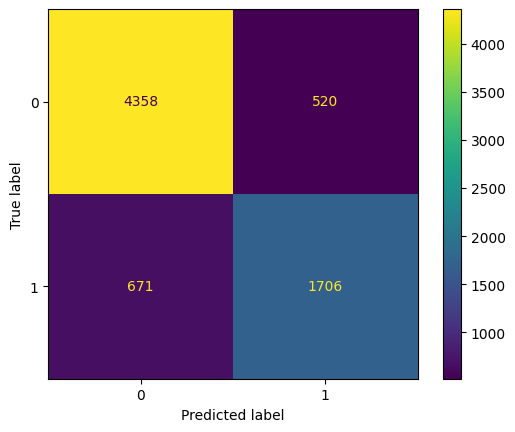

In [80]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
recall_total_train = 0
recall_total_test = 0
for i in y_train.unique():
    print(f'Recall for label {i} - Train:', recall_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'Recall for label {i} - Test:', recall_score(y_test, y_pred_test, pos_label=i) * 100)
    recall_total_train += recall_score(y_train, y_pred_train, pos_label=i) * 100
    recall_total_test += recall_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of Recall - Train:', recall_total_train/len(y_train.unique()))
print('Average of Recall - Test:', recall_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())
score_reports = {
    'Accuracy - Train': accuracy_score(y_train, y_pred_train) * 100,
    'Recall for Not Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=0) * 100,
    'Recall for Cancelled - Train': recall_score(y_train, y_pred_train, pos_label=1) * 100,
    'Average of Recall - Train': recall_total_train/len(y_train.unique()),
    'Accuracy - Test': accuracy_score(y_test, y_pred_test) * 100,
    'Recall for Not Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=0) * 100,
    'Recall for Cancelled - Test': recall_score(y_test, y_pred_test, pos_label=1) * 100,
    'Average of Recall - Test': recall_total_test/len(y_train.unique()),
}
all_reports['Random Forest (Tuned)'] = score_reports

### Analysis of Evaluation

In [81]:
pd.DataFrame(all_reports).T

,Accuracy - Train,Recall for Not Cancelled - Train,Recall for Cancelled - Train,Average of Recall - Train,Accuracy - Test,Recall for Not Cancelled - Test,Recall for Cancelled - Test,Average of Recall - Test
Naive Bayes (Baselined),51.050999,29.499795,95.277661,62.388728,51.274983,29.766298,95.414388,62.590343
Naive Bayes (Tuned),51.206065,29.745797,95.246109,62.495953,51.343901,29.868799,95.414388,62.641593
XGBoost (Baselined),84.800138,90.457155,73.190997,81.824076,83.928325,89.442394,72.612537,81.027466
XGBoost (Tuned),83.924879,89.109266,73.285654,81.197460,83.280496,88.212382,73.159445,80.685913
Random Forest (Baseline),86.784976,92.168922,75.736222,83.952572,82.825637,88.929889,70.298696,79.614293
Random Forest (Tuned),85.668504,91.215662,74.284813,82.750237,83.583735,89.339893,71.771140,80.555517


Dari hasil evaluasi diatas, model terbaik di cross validation yaitu **Naive Bayes** memiliki recall yang bagus untuk class **Canceled** (**95,41%**) saja dimana recall untuk class **Not Canceled** hanya memiliki score recall **29,86%** saja. Untuk model terbaik setelah dilakukan Hyperparameter Tuning ialah model **XGBoost** dengan rata - rata recall sebesar **80,68%**. Akan tetapi model **XGBoost** mengalami penurunan setelah dilakukan Hyperparameter Tuning dimana rata - rata recall pada baseline model sebesar **81,02%** sedangkan setelah di tuning sebesar **80,68%** atau mengalami penurunan sebesar **0,34%**. Berbeda dengan model **Random Forest** dan **Naive Bayes** dimana kedua model tersebut mendapatkan peningkatan nilai recall setelah dilakukan hyperparameter tuning dengan rata - rata nilai recall pada data train sebesar **79,61%** dan data test sebesar **80,55%** untuk model **Random Forest** dan rata - rata nilai recall pada data train sebesar **62,59%** dan data test sebesar **62,64%** pada model **Naive Bayes**. Sehingga model yang disimpan dan digunakan ialah model XGBoost baseline atau dengan parameter default.

# Model Saving

In [82]:
with open('deployment/model.pkl', 'wb') as file_1:
    joblib.dump(xgb_model, file_1)

# Model Inference

Untuk model inference dapat di cek pada file `h8dsft_P1M2_Arvin Melvillo_Inference.ipynb`

# Pengambilan Kesimpulan

Data terdiri dari 19 kolom yang dimana data yang memiliki keterkaitan dengan **booking_status** hanya ada 7 column saja yaitu data **lead_time**, **no_of_special_requests**, **type_of_meal_plan**, **required_car_parking_space**, **room_type_reserved**, **market_segment_type** dan **repeated_guest**. Kebanyakan customer hotel merupakan customer hotel yang baru **bukan customer yang sudah pernah menginap sebelumnya**. Selain itu customer merupakan tourist yang **tidak membutuhkan lahan parkir**. Customer Liburan skuy juga cenderung membooking via **Online**, memesan tipe kamar **1**, dan tipe makanan **1**.\
Dari 7 model yang telah dijalankan, 3 performa terbaik dengan validasi silang didapatkan oleh base model **Naive Bayes**, **XGBoost**, dan **Random Forest** dengan rata - rata recall pada label 1 selama validasi silang sebesar **95,23%** , **71,49%**, dan **69,604%**. Setelah dilakukan Hyperparameter tuning, model terbaik di cross validation yaitu **Naive Bayes** memiliki recall yang bagus untuk class **Canceled** (**95,41%**) saja dimana recall untuk class **Not Canceled** hanya memiliki score recall **29,86%** saja. Untuk model terbaik setelah dilakukan Hyperparameter Tuning ialah model **XGBoost** dengan rata - rata recall sebesar **80,68%**. Akan tetapi model **XGBoost** mengalami penurunan setelah dilakukan Hyperparameter Tuning dimana rata - rata recall pada baseline model sebesar **81,02%** sedangkan setelah di tuning sebesar **80,68%** atau mengalami penurunan sebesar **0,34%**. \
Hasil evaluasi model **XGBoost** terbaik mendapatkan rata - rata recall sebesar **81,02%** . Selain itu model XGBoost ini juga dikatakan sudah good fit karena hasil evaluasi pada data train dengan data test tidak berbeda jauh dimana data train memiliki rata-rata recall sebesar **81,82%** dan pada data test sebesar **81,02%**. \
Untuk improvement kedepannya, dapat dimulai dari mengumpulkan data - data booking terutama berfokus kepada booking yang dibatalkan. Karena dari hasil yang diprediksi, data booking yang **dibatalkan** memiliki hasil evaluasi yang rendah dibandingkan kelas yang **tidak dibatalkan**. Hal ini terjadi karena adanya data imbalance yang minority classnya merupakan **booking yang dibatalkan**. Oleh karena itu selain melakukan pengumpulan data, next stepnya adalah membuat model machine learning dengan fitur **booking yang dibatalkan** di oversampling untuk menyamakan banyaknya kelas **booking yang dibatalkan** dengan kelas **booking yang tidak dibatalkan**. 